In [ ]:
# Google drive link:  https://drive.google.com/drive/folders/1WBqpfST0lEyg3sSPHZPUXeCAX5__XdEa?usp=sharing

In [ ]:
# RAMS dataset link:  https://nlp.jhu.edu/rams/

In [ ]:
import os
import json
import pandas as pd
import numpy as np
import tensorflow as tf
from google.colab import drive
drive.mount('/content/drive')

train_data_path = "/content/drive/MyDrive/code/train.jsonlines"
dev_data_path = "/content/drive/MyDrive/code/dev.jsonlines"
test_data_path = "/content/drive/MyDrive/code/test.jsonlines"

# train_data_path = "train.jsonlines"
# dev_data_path = "dev.jsonlines"
# test_data_path = "test.jsonlines"

def load_jsonlines(filepath):
  data = []
  with open(filepath, 'r') as f:
    for line in f:
      data.append(json.loads(line))
  return data

train_data = load_jsonlines(train_data_path)
dev_data = load_jsonlines(dev_data_path)
test_data = load_jsonlines(test_data_path)

print(f"Loaded {len(train_data)} training examples.")
print(f"Loaded {len(dev_data)} development examples.")
print(f"Loaded {len(test_data)} test examples.")
print("Sample training record:", train_data[0])

Mounted at /content/drive
Loaded 7329 training examples.
Loaded 924 development examples.
Loaded 871 test examples.
Sample training record: {'rel_triggers': [], 'gold_rel_links': [], 'doc_key': 'nw_RC000462ebb18ca0b29222d5e557fa31072af8337e3a0910dca8b5b62f', 'ent_spans': [[42, 43, [['evt090arg02victim', 1.0]]], [85, 88, [['evt090arg01killer', 1.0]]], [26, 26, [['evt090arg04place', 1.0]]]], 'language_id': 'eng', 'source_url': 'https://www.washingtonpost.com/news/powerpost/paloma/daily-202/2016/06/17/daily-202-more-republicans-ditch-trump-conclude-he-cannot-win/5763a1e0981b92a22d0f8a36/', 'evt_triggers': [[69, 69, [['life.die.deathcausedbyviolentevents', 1.0]]]], 'split': 'train', 'sentences': [['Transportation', 'officials', 'are', 'urging', 'carpool', 'and', 'teleworking', 'as', 'options', 'to', 'combat', 'an', 'expected', 'flood', 'of', 'drivers', 'on', 'the', 'road', '.'], ['(', 'Paul', 'Duggan', ')'], ['--', 'A', 'Baltimore', 'prosecutor', 'accused', 'a', 'police', 'detective', 'of'

In [ ]:
for item in train_data[:2]:  # Iterate through the first 2 items of train_data
    print(item)

{'rel_triggers': [], 'gold_rel_links': [], 'doc_key': 'nw_RC000462ebb18ca0b29222d5e557fa31072af8337e3a0910dca8b5b62f', 'ent_spans': [[42, 43, [['evt090arg02victim', 1.0]]], [85, 88, [['evt090arg01killer', 1.0]]], [26, 26, [['evt090arg04place', 1.0]]]], 'language_id': 'eng', 'source_url': 'https://www.washingtonpost.com/news/powerpost/paloma/daily-202/2016/06/17/daily-202-more-republicans-ditch-trump-conclude-he-cannot-win/5763a1e0981b92a22d0f8a36/', 'evt_triggers': [[69, 69, [['life.die.deathcausedbyviolentevents', 1.0]]]], 'split': 'train', 'sentences': [['Transportation', 'officials', 'are', 'urging', 'carpool', 'and', 'teleworking', 'as', 'options', 'to', 'combat', 'an', 'expected', 'flood', 'of', 'drivers', 'on', 'the', 'road', '.'], ['(', 'Paul', 'Duggan', ')'], ['--', 'A', 'Baltimore', 'prosecutor', 'accused', 'a', 'police', 'detective', 'of', '“', 'sabotaging', '”', 'investigations', 'related', 'to', 'the', 'death', 'of', 'Freddie', 'Gray', ',', 'accusing', 'him', 'of', 'fabrica

The below is evt_triggers and sentences of one row, 51, 51 indicating the index of trigger token which is smuggled

 {"evt_triggers": [[51, 51, [["movement.transportartifact.hide", 1.0]]]],   "sentences": [["2014", ":", "ISIS", "marches", "into", "Raqqa", "and", "makes", "it", "the", "capital", "of", "the", "caliphate", "."], ["Foto", ":", "Uncredited"], ["The", "two", "Syrian", "women", "who", "we", "shall", "call", "Om", "Omran", "and", "Om", "Mohammad", ",", "which", "are", "not", "their", "real", "names", ",", "were", "willing", "to", "wear", "Expressen", "'s", "hidden", "cameras", ",", "which", "have", "been", "smuggled", "in", "."], ["\"", "We", "want", "the", "world", "to", "know", ",", "\"", "they", "say", "."], ["Over", "the", "course", "of", "several", "weeks", ",", "they", "have", "documented", "life", "in", "the", "completely", "isolated", "city", "of", "al", "-", "Raqqah", "."]]}\

In [ ]:
def preprocess_rams(data):
    texts = []
    src_labels = []
    event_triggers = []
    event_types = []

    for entry in data:
        sentences = entry['sentences']
        triggers = entry['evt_triggers']

        flat_sentences = [token for sentence in sentences for token in sentence]
        for i, sentence in enumerate(sentences):
            text = ' '.join(sentence).replace(" .", ".").strip()
            texts.append(text)

            src_label = "NONE"
            event_trigger = "NONE"
            event_type = "NONE"

            # Check for triggers in the current entry
            if triggers:  # If there are event triggers
                for trigger in triggers:
                    start_idx, end_idx, event_info = trigger

                    # Check if the start and end indices are valid in the flattened token list
                    if start_idx < len(flat_sentences) and end_idx < len(flat_sentences):
                        # Get the trigger word from the flattened tokens
                        event_trigger_candidate = flat_sentences[start_idx]  # Use the start index for the trigger

                        # Check if the trigger word is in the current sentence
                        if event_trigger_candidate in sentence:
                            event_type_full = event_info[0][0]
                            event_type = '.'.join(event_type_full.split('.')[:2])

                            src_label = f"{event_trigger_candidate}->{event_type}"
                            event_trigger = event_trigger_candidate
                            break
            src_labels.append(src_label)
            event_triggers.append(event_trigger)
            event_types.append(event_type)

    df = pd.DataFrame({
        'text': texts,
        'src_label': src_labels,
        'event_triggers': event_triggers,
        'event_types': event_types
    })
    return df

In [ ]:
train_df = preprocess_rams(train_data)
# reomve the non event rows
train_df = train_df[train_df['src_label'] != 'NONE']
dev_df = preprocess_rams(dev_data)
dev_df = dev_df[dev_df['src_label'] != 'NONE']
test_df = preprocess_rams(test_data)
test_df = test_df[test_df['src_label'] != 'NONE']
print(train_df.head())

                                                 text  \
2   -- A Baltimore prosecutor accused a police det...   
7   The two Syrian women who we shall call Om Omra...   
12  Twelve months after that , he was found in Geo...   
17  The images are the color of asphalt , and the ...   
22  Since the S-400 deployment , the U.S. military...   

                                          src_label event_triggers  \
2                                homicide->life.die       homicide   
7              smuggled->movement.transportartifact       smuggled   
12                          battle->conflict.attack         battle   
17                            sickness->life.injure       sickness   
22  pledges->contact.commitmentpromiseexpressintent        pledges   

                               event_types  
2                                 life.die  
7               movement.transportartifact  
12                         conflict.attack  
17                             life.injure  
22  contact

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8445 entries, 2 to 35532
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   text            8445 non-null   object
 1   src_label       8445 non-null   object
 2   event_triggers  8445 non-null   object
 3   event_types     8445 non-null   object
dtypes: object(4)
memory usage: 329.9+ KB


In [ ]:
#********************multitask learning********************

In [ ]:
from transformers import TFDistilBertForSequenceClassification, DistilBertTokenizerFast
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [ ]:
def tokenize_data(texts, max_length=128):
    return tokenizer(texts.tolist(), padding='max_length', truncation=True, max_length=max_length, return_tensors='tf')

train_encodings = tokenize_data(train_df['text'])
dev_encodings = tokenize_data(dev_df['text'])
test_encodings = tokenize_data(test_df['text'])

# Create event type mapping
all_event_types = set(train_df['event_types'].unique())
all_event_types.update(dev_df['event_types'].unique())
all_event_types.update(test_df['event_types'].unique())
event_type_mapping = {label: idx for idx, label in enumerate(all_event_types)}

all_event_triggers = set(train_df['event_triggers'].unique())
all_event_triggers.update(dev_df['event_triggers'].unique())
all_event_triggers.update(test_df['event_triggers'].unique())
event_trigger_mapping = {label: idx for idx, label in enumerate(all_event_triggers)}

def map_event_type(event_type):
    if not event_type_mapping:
        raise ValueError("Event type mapping is empty.")
    return event_type_mapping.get(event_type, event_type_mapping[list(event_type_mapping.keys())[0]])

def map_event_trigger(trigger):
    if not event_trigger_mapping:
        raise ValueError("Event trigger mapping is empty.")
    return event_trigger_mapping.get(trigger, event_trigger_mapping[list(event_trigger_mapping.keys())[0]])

train_event_type_labels = train_df['event_types'].map(event_type_mapping).values
dev_event_type_labels = dev_df['event_types'].map(event_type_mapping).values
test_event_type_labels = test_df['event_types'].map(event_type_mapping).values

train_labels = train_df['event_triggers'].map(event_trigger_mapping).values
dev_labels = dev_df['event_triggers'].map(event_trigger_mapping).values
test_labels = test_df['event_triggers'].map(event_trigger_mapping).values

BATCH_SIZE = 16

# Prepare the dataset with two labels
train_dataset = tf.data.Dataset.from_tensor_slices(
    (dict(train_encodings), {'trigger_output': train_labels, 'event_type_output': train_event_type_labels})
).batch(BATCH_SIZE)

dev_dataset = tf.data.Dataset.from_tensor_slices(
    (dict(dev_encodings), {'trigger_output': dev_labels, 'event_type_output': dev_event_type_labels})
).batch(BATCH_SIZE)

test_dataset = tf.data.Dataset.from_tensor_slices(
    (dict(test_encodings), {'trigger_output': test_labels, 'event_type_output': test_event_type_labels})
).batch(BATCH_SIZE)

In [ ]:
# batch_size = 16
# print("Dataset properties:")
# print(f"Number of batches train_dataset: {len(list(train_dataset))}")
# print(f"First batch shape: {list(train_dataset.take(1))}")

# for i, (inputs, outputs) in enumerate(train_dataset.take(1)):
#     print(f"\nBatch {i + 1}:")

#     for key in inputs:
#         print(f"{key} shape: {inputs[key].shape}")
#         print(f"{key} sample values: {inputs[key].numpy()}")

#     for output_key, output_value in outputs.items():
#         print(f"{output_key} shape: {output_value.shape}")
#         print(f"{output_key} sample values: {output_value.numpy()}")

In [ ]:
from tensorflow import keras
from transformers import TFDistilBertModel

In [ ]:
class CustomModel(tf.keras.Model):
    def __init__(self, trigger_num_labels, event_type_num_labels, dropout_rate=0.3):
        super(CustomModel, self).__init__()

        # Base Model
        self.distilbert = TFDistilBertModel.from_pretrained('distilbert-base-uncased')

        # Shared Dense Layer
        self.shared_dense = tf.keras.layers.Dense(
            512, activation='relu', name='shared_dense'
        )

        # Dropout Layer
        self.dropout = tf.keras.layers.Dropout(dropout_rate, name='dropout')

        # Normalization Layer
        self.normalization = tf.keras.layers.LayerNormalization(name='layer_norm')

        # Task-specific Dense Layers
        self.trigger_classifier = tf.keras.layers.Dense(
            trigger_num_labels, activation='softmax', name='trigger_output'
        )
        self.event_type_classifier = tf.keras.layers.Dense(
            event_type_num_labels, activation='softmax', name='event_type_output'
        )

    def call(self, inputs):
        distilbert_output = self.distilbert(inputs).last_hidden_state[:, 0, :]

        # Shared Dense Layer with Dropout and Normalization
        shared_output = self.shared_dense(distilbert_output)
        shared_output = self.dropout(shared_output)
        shared_output = self.normalization(shared_output)

        # Task-specific Outputs
        trigger_output = self.trigger_classifier(shared_output)
        event_type_output = self.event_type_classifier(shared_output)

        return {
            'trigger_output': trigger_output,
            'event_type_output': event_type_output
        }

model = CustomModel(trigger_num_labels=len(event_trigger_mapping), event_type_num_labels=len(event_type_mapping))
lr_schedule = tf.keras.optimizers.schedules.CosineDecayRestarts(
    initial_learning_rate=3e-5,
    first_decay_steps=1000,
    t_mul=2.0,
    m_mul=1.0,
    alpha=0.0
)


optimizer = tf.keras.optimizers.AdamW(learning_rate=lr_schedule, weight_decay=5e-5, clipvalue=0.8)
callbacks = [
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True),
    keras.callbacks.ModelCheckpoint(
        'best_model',
        save_best_only=True,
        monitor='val_trigger_output_loss',
        save_weights_only=True
    )
]
model.compile(optimizer=optimizer,
              loss={'trigger_output': tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                    'event_type_output': tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)},
              metrics={'trigger_output': 'accuracy', 'event_type_output': 'accuracy'}, run_eagerly=True)

history = model.fit(train_dataset, validation_data=dev_dataset, epochs=25, batch_size=16, callbacks=callbacks)
print(model.summary())
print(history.history)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Epoch 1/25


528/528 [==============================] - 313s 568ms/step - loss: 8.6801 - event_type_output_loss: 2.4607 - trigger_output_loss: 6.2194 - event_type_output_accuracy: 0.3594 - trigger_output_accuracy: 0.0750 - val_loss: 6.4741 - val_event_type_output_loss: 1.3777 - val_trigger_output_loss: 5.0964 - val_event_type_output_accuracy: 0.5843 - val_trigger_output_accuracy: 0.2372
Epoch 2/25
528/528 [==============================] - 281s 532ms/step - loss: 6.2131 - event_type_output_loss: 1.2494 - trigger_output_loss: 4.9637 - event_type_output_accuracy: 0.6459 - trigger_output_accuracy: 0.2694 - val_loss: 5.8128 - val_event_type_output_loss: 1.3109 - val_trigger_output_loss: 4.5018 - val_event_type_output_accuracy: 0.6231 - val_trigger_output_accuracy: 0.3282
Epoch 3/25
528/528 [==============================] - 272s 516ms/step - loss: 5.2251 - event_type_output_loss: 1.1353 - trigger_output_loss: 4.0898 - event_type_output_accuracy: 0.6772 - trigger_output_accuracy: 0.4092 - val_loss: 4.42

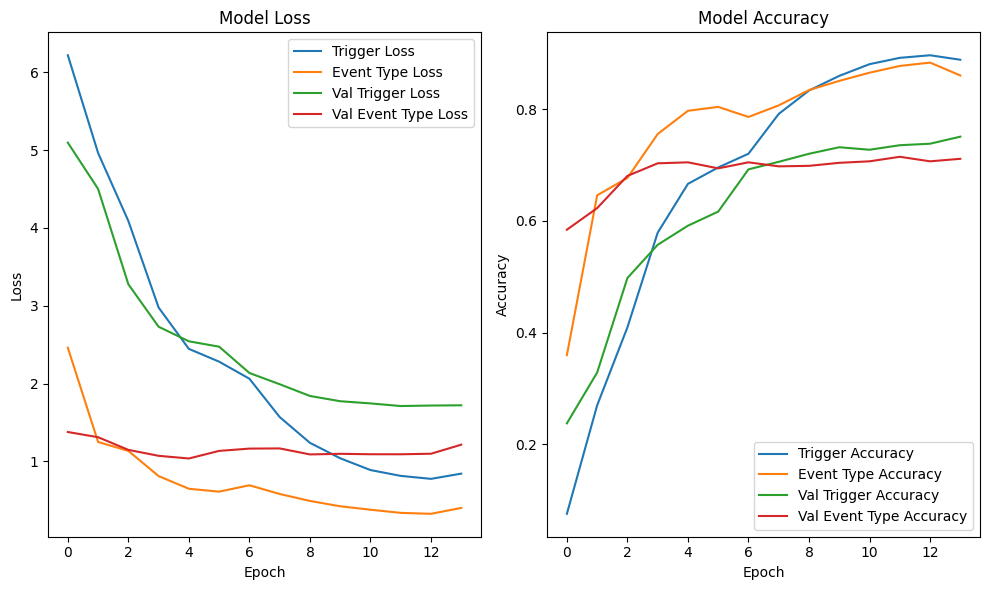

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))

# Plot loss for both tasks
plt.subplot(1, 2, 1)
plt.plot(history.history['trigger_output_loss'], label='Trigger Loss')
plt.plot(history.history['event_type_output_loss'], label='Event Type Loss')
plt.plot(history.history['val_trigger_output_loss'], label='Val Trigger Loss')
plt.plot(history.history['val_event_type_output_loss'], label='Val Event Type Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['trigger_output_accuracy'], label='Trigger Accuracy')
plt.plot(history.history['event_type_output_accuracy'], label='Event Type Accuracy')
plt.plot(history.history['val_trigger_output_accuracy'], label='Val Trigger Accuracy')
plt.plot(history.history['val_event_type_output_accuracy'], label='Val Event Type Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import classification_report
results = model.evaluate(test_dataset)

print("Evaluation Results:")
for metric_name, metric_value in zip(model.metrics_names, results):
    print(f"{metric_name}: {metric_value}")

predictions = model.predict(test_dataset)
trigger_predictions = predictions['trigger_output']
event_type_predictions = predictions['event_type_output']

trigger_predicted_labels = tf.argmax(trigger_predictions, axis=1).numpy()
event_type_predicted_labels = tf.argmax(event_type_predictions, axis=1).numpy()

trigger_true_labels = test_labels
event_type_true_labels = test_event_type_labels
# ----------------------------------Changes for event type-------------------------------------
unique_event_types_test = set(event_type_true_labels).union(set(event_type_predicted_labels))

# Filter event_type_mapping to include only the unique event types present in test data
filtered_event_type_target_names = [label for label, idx in event_type_mapping.items() if idx in unique_event_types_test]

# ----------------------------------------------------------------------------------------------

unique_labels = set(trigger_true_labels).union(set(trigger_predicted_labels))
filtered_target_names = [label for label, idx in event_trigger_mapping.items() if idx in unique_labels]

print("\nClassification Report for Trigger Prediction:")
print(classification_report(
    trigger_true_labels,
    trigger_predicted_labels,
    target_names=filtered_target_names,
    zero_division=0  # Avoid warnings for classes not in test set
))
print("\nClassification Report for Event Type Prediction:")
print(classification_report(
    event_type_true_labels,
    event_type_predicted_labels,
    target_names=filtered_event_type_target_names,
    zero_division=0
))

65/65 [==============================] - 11s 169ms/step - loss: 2.4774 - event_type_output_loss: 0.9562 - trigger_output_loss: 1.5211 - event_type_output_accuracy: 0.7198 - trigger_output_accuracy: 0.7758
Evaluation Results:
loss: 2.4773526191711426
event_type_output_loss: 0.9562181234359741
trigger_output_loss: 1.5211350917816162
event_type_output_accuracy: 0.7198067903518677
trigger_output_accuracy: 0.7758454084396362
65/65 [==============================] - 7s 103ms/step

Classification Report for Trigger Prediction:
               precision    recall  f1-score   support

        annex       0.86      1.00      0.92         6
   starvation       1.00      1.00      1.00         4
          spy       1.00      0.83      0.91         6
      elected       1.00      1.00      1.00         4
     captured       0.83      0.83      0.83         6
      suggest       1.00      0.50      0.67         4
 establishing       0.00      0.00      0.00         1
    advocated       0.60      1.0

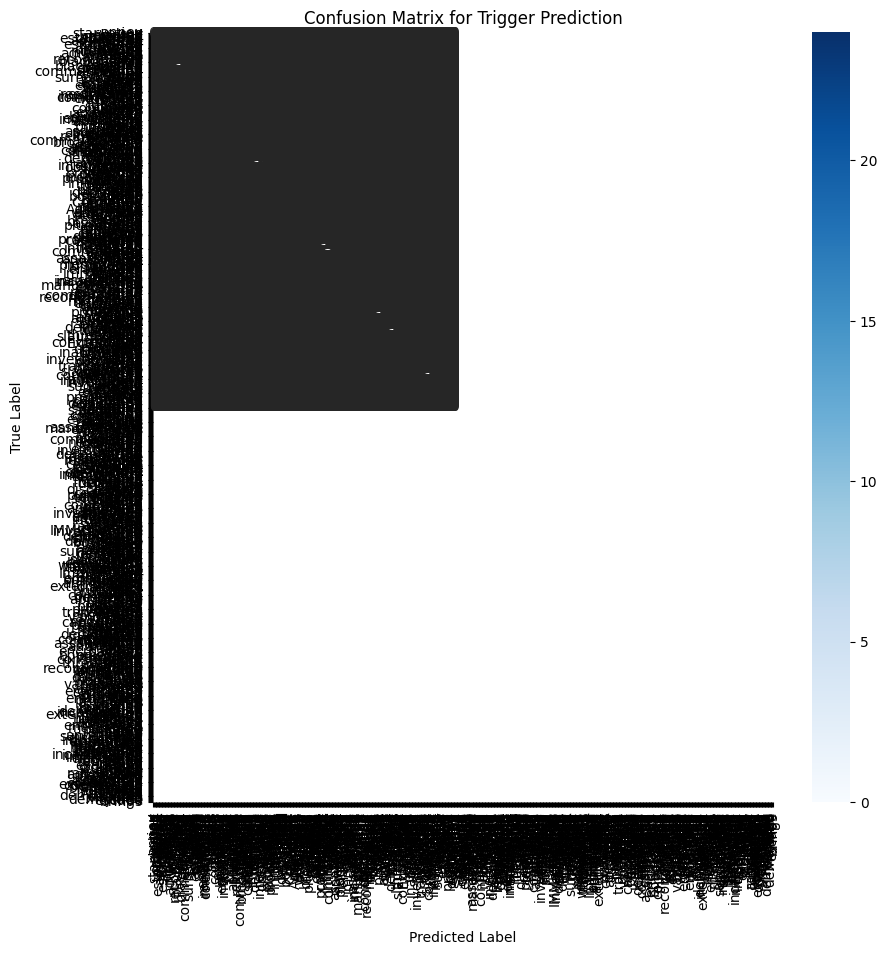

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Assuming 'trigger_true_labels' and 'trigger_predicted_labels' are defined
# as in your provided code.

cm = confusion_matrix(trigger_true_labels, trigger_predicted_labels)
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=list(event_trigger_mapping.keys()),
            yticklabels=list(event_trigger_mapping.keys()))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Trigger Prediction')
plt.show()

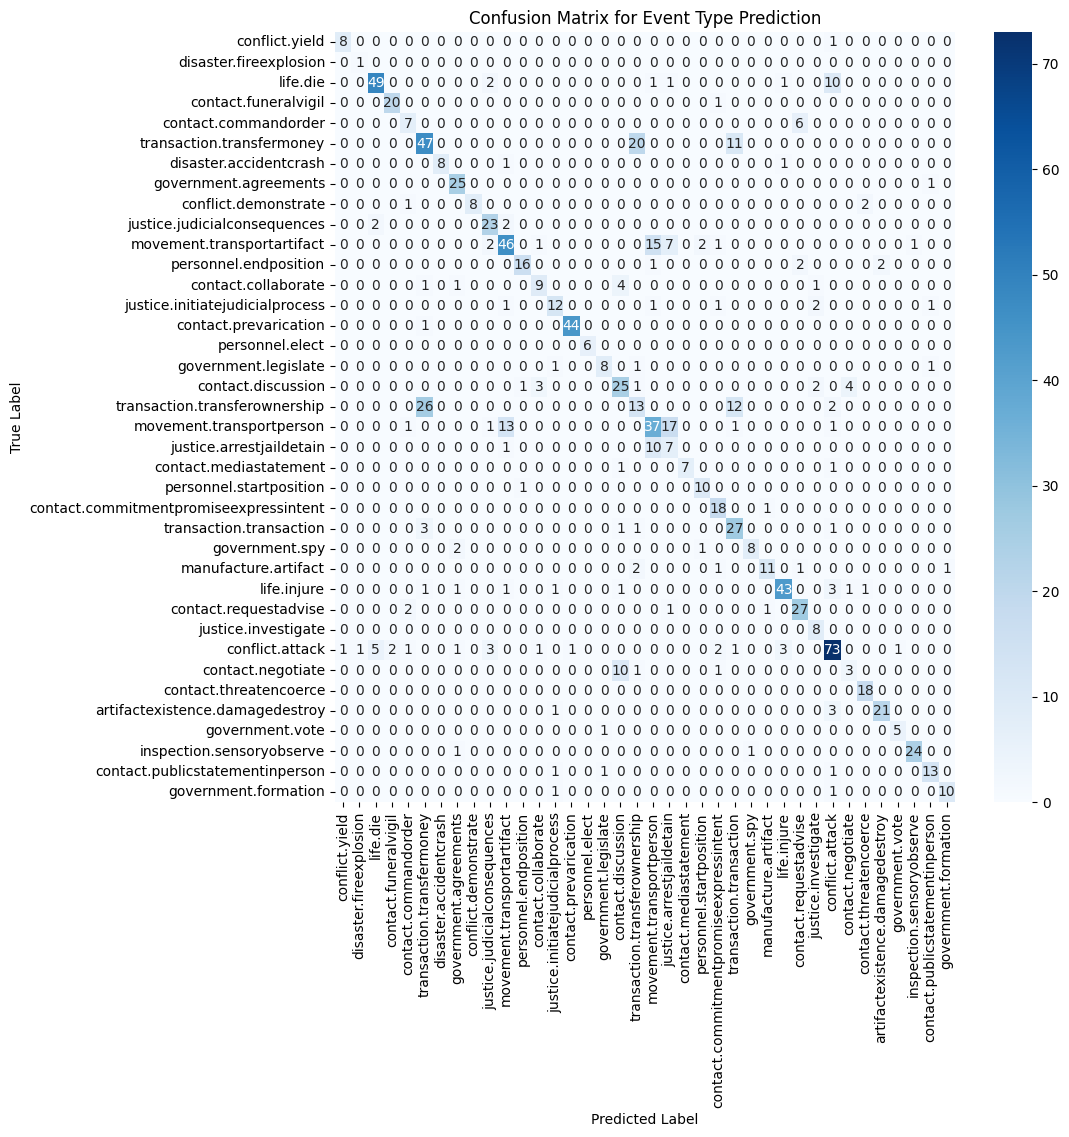

In [ ]:

cm_event_type = confusion_matrix(event_type_true_labels, event_type_predicted_labels)
plt.figure(figsize=(10, 10))
sns.heatmap(cm_event_type, annot=True, fmt='d', cmap='Blues',
            xticklabels=list(event_type_mapping.keys()),
            yticklabels=list(event_type_mapping.keys()))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Event Type Prediction')
plt.show()

In [ ]:

new_sentences = [
    "The court ruled in favor of the defendant in the recent trial.",
    "The children were evacuated safely from the building.",
    "The hospital receives 20-30 casualties from Israeli air strikes a day. Most are civilians, but no-one is turned away. “We take all patients, and all injured, and all martyrs who come,” he says. “We don't discriminate between them",
    "A Baltimore prosecutor accused a police detective of “sabotaging” investigations related to the death of Freddie Gray, accusing him of fabricating notes to suggest that the state’s medical examiner believed the manner of death was an accident rather than a homicide."
]

new_encodings = tokenizer(new_sentences, padding='max_length', truncation=True, max_length=128, return_tensors='tf')
predictions = model.predict(dict(new_encodings))

# 5. Get predicted labels for both tasks
trigger_predicted_labels = tf.argmax(predictions['trigger_output'], axis=1).numpy()
event_type_predicted_labels = tf.argmax(predictions['event_type_output'], axis=1).numpy()

# 6. Map predicted labels back to original labels
predicted_triggers = [list(event_trigger_mapping.keys())[i] for i in trigger_predicted_labels]
predicted_event_types = [list(event_type_mapping.keys())[i] for i in event_type_predicted_labels]

for i, sentence in enumerate(new_sentences):
    print(f"Sentence: {sentence}")
    print(f"Predicted Trigger: {predicted_triggers[i]}")
    print(f"Predicted Event Type: {predicted_event_types[i]}")
    print("-" * 20)

1/1 [==============================] - 0s 138ms/step
Sentence: The court ruled in favor of the defendant in the recent trial.
Predicted Trigger: trial
Predicted Event Type: justice.initiatejudicialprocess
--------------------
Sentence: The children were evacuated safely from the building.
Predicted Trigger: evacuated
Predicted Event Type: movement.transportperson
--------------------
Sentence: The hospital receives 20-30 casualties from Israeli air strikes a day. Most are civilians, but no-one is turned away. “We take all patients, and all injured, and all martyrs who come,” he says. “We don't discriminate between them
Predicted Trigger: strikes
Predicted Event Type: life.injure
--------------------
Sentence: A Baltimore prosecutor accused a police detective of “sabotaging” investigations related to the death of Freddie Gray, accusing him of fabricating notes to suggest that the state’s medical examiner believed the manner of death was an accident rather than a homicide.
Predicted Trig

In [ ]:
#************************dummy****************

In [ ]:
import plotly.graph_objects as go

fig = go.Figure(go.Sankey(
    node=dict(
        pad=20,
        thickness=30,
        line=dict(color="black", width=0.5),
        label=[
            "Sentence", "Trigger", "Event Type",
            "trial", "evacuated", "strikes", "homicide",
            "justice.initiatejudicialprocess",
            "movement.transportperson",
            "life.injure",
            "life.die"
        ],
        color=["lightgray", "lightblue", "lightgreen",
               "orange", "orange", "orange", "orange",
               "blue", "blue", "blue", "blue"]
    ),
    link=dict(
        source=[0, 0, 0, 0, 3, 4, 5, 6],  # Source node indices
        target=[1, 1, 1, 1, 7, 8, 9, 10],  # Target node indices
        value=[1, 1, 1, 1, 1, 1, 1, 1],  # Link values
        color=["gray"] * 8  # Uniform link colors
    )
))

fig.update_layout(
    title_text="Predicted Triggers and Event Types",
    font_size=12
)
fig.show()
